# Introduction

For companies to become competitive and skyrocket their growth, they need to leverage AI/ML to develop predictive models to forecast sales in the future. Predictive models attempt at forecasting future sales based on historical data while taking into account seasonality effects, demand, holidays, promotions, and competition.
The sales team at Rossman provided a dataset with data from 1115 stores and another dataset containing all the sales transactions made.  

Store dataset comprise of the following columns:
- Store: unique store Id
- StoreType: categorical variable to indicate type of store (a, b, c, d)
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance (meters): distance to closest competitor store
- CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
- Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- Promo2Since [Year/Week]: date when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Sales dataset comprise of the following columns:
- Id: transaction ID (combination of Store and date) 
- Store: unique store Id
- Sales: sales/day, this is the target variable 
- Customers: number of customers on a given day
- Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
- Promo: describes if store is running a promo on that day or not
- StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

The datasets can be accessed on Kaggle at https://www.kaggle.com/c/rossmann-store-sales/data

### Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import datetime as dt

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

C:\Users\Abderraouf\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Analysis/Modeling

Let's start by reading our data sets and explore the overall statistical properties.

In [2]:
store_df = pd.read_csv('./Dataset/store.csv')
sales_df = pd.read_csv('./Dataset/train.csv')

C:\Users\Abderraouf\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Our store dataset has 1115 stores with 10 features.

In [4]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


On average, the stores are around 5404m away from their nearest competition with the closest being 1m and the furthest being 75860m.

Now lets do the same for our sales dataset.

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Our sales dataset 9 features across 1017209 transactions.

In [6]:
sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


The average sales amount per day for a store is 5773 Euros, with the minimum sales per day equalling 0 Euros and maximum sales per day being 41551 Euros.
The average number of customers per store is 633 with the minimum number of customers being 0, maximum number of customers equalling 7388.

Let's explore this dataset further!

In [7]:
sales_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

There are no missing values. let's look at the distribution of the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012352467A08>,
      dtype=object)

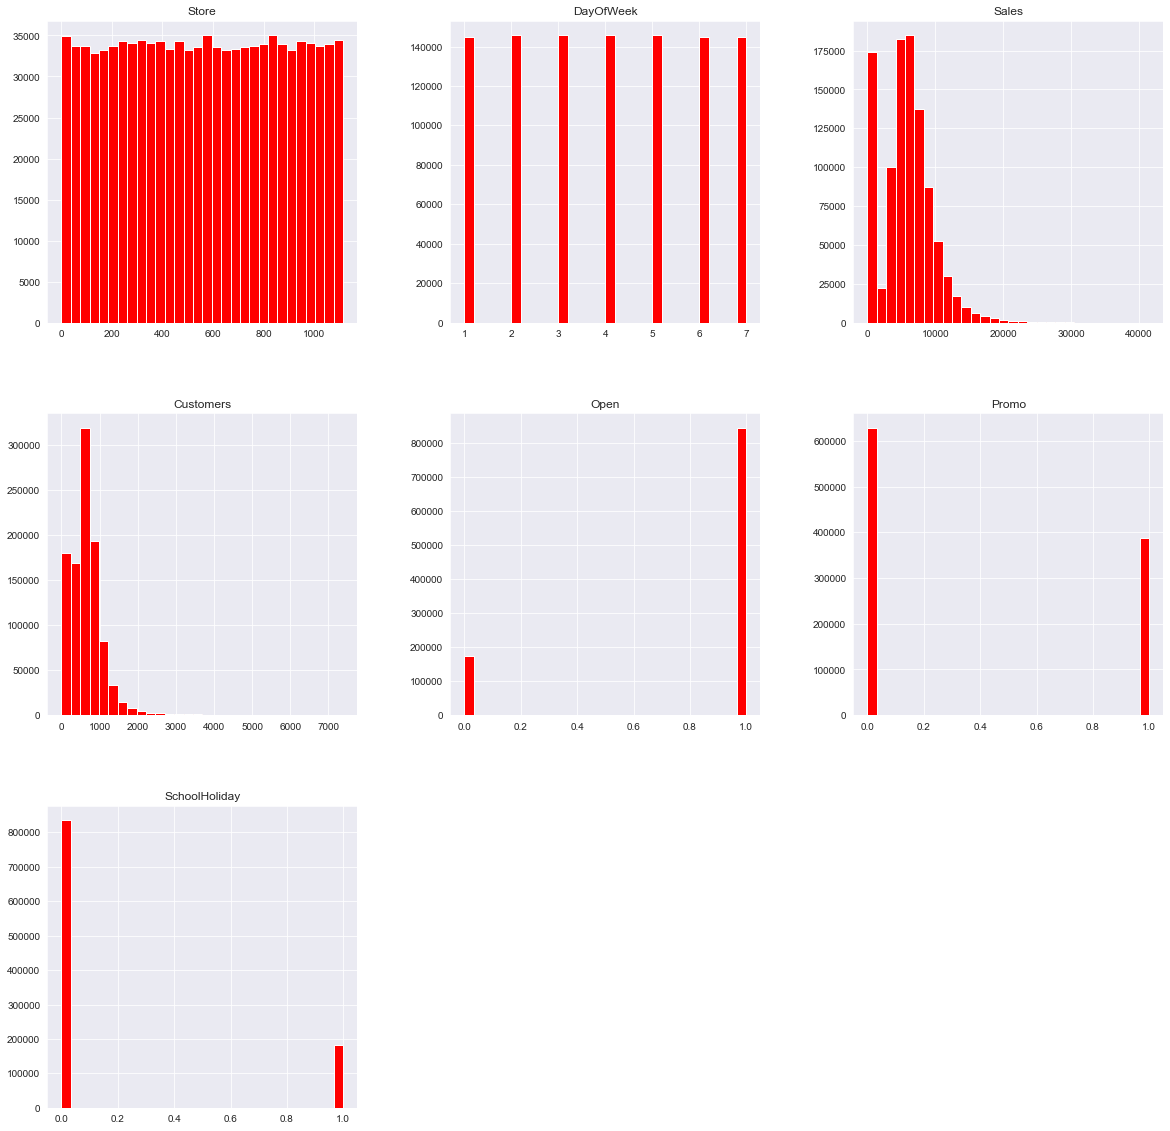

In [8]:
sales_df.hist(bins = 30, figsize = (20,20), color = 'r')

We have an average of 600 customers per day, with a maximum of 4500. We most likely have an outlier that can't be seen in the graph (our x axis is in 0-8000 range). Our data is equally distributed across all days of the week, with about 150000 observations per day. 80% of the stores are open, while the 20% of sales are closed. The data is distributed evenly among all stores. The average sales is around 5000-6000 Euros. Promos ran 40% of the time, while school holidays had an effect on store sales around 18% of the time.

Since we have stores that have been closed, we need to remove them from our dataset, since we cant use them to make future predictions. We also can drop the open column since it is redundant.

In [9]:
sales_df = sales_df[sales_df['Open'] == 1]
sales_df.drop(['Open'], axis=1, inplace=True)
sales_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


Our average number of customers and sales have increased! Average sales went from 5773 Euros to  6955 Euros, with customers going from 633 to 762. Let's do the same analysis to our store dataset.

In [10]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We have quite a bit of missing data in this set. Let's look at each of these features

In [11]:
store_df[store_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [12]:
store_df[store_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [13]:
store_df[store_df['Promo2SinceWeek'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


It seems like if 'promo2' is zero, then the other columns which relates to it such as 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is set to null which makes sense since they do not exist. Let's set these values to zeros.

In [14]:
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

for str in str_cols:
    store_df [str].fillna(0, inplace = True)

There are 3 rows with 'competitionDistance' values missing, we can use mean impute to fill them up since we have the majority of the data.

In [15]:
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].mean(), inplace = True)

Let's take a look at our null values again.

In [16]:
store_df.isnull().sum()/len(store_df)*100

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

It seems like we are missing 32% of data in the Competition Open categories for month and year. This is a big chunk of data. These values are very hard to product using standard imputation method. We will drop these two features instead.

In [17]:
store_df.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)
store_df.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Promo2SinceWeek        0
Promo2SinceYear        0
PromoInterval          0
dtype: int64

All missing values have been handled. Let's look at the distributions. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012368B6BB88>,
      dtype=object)

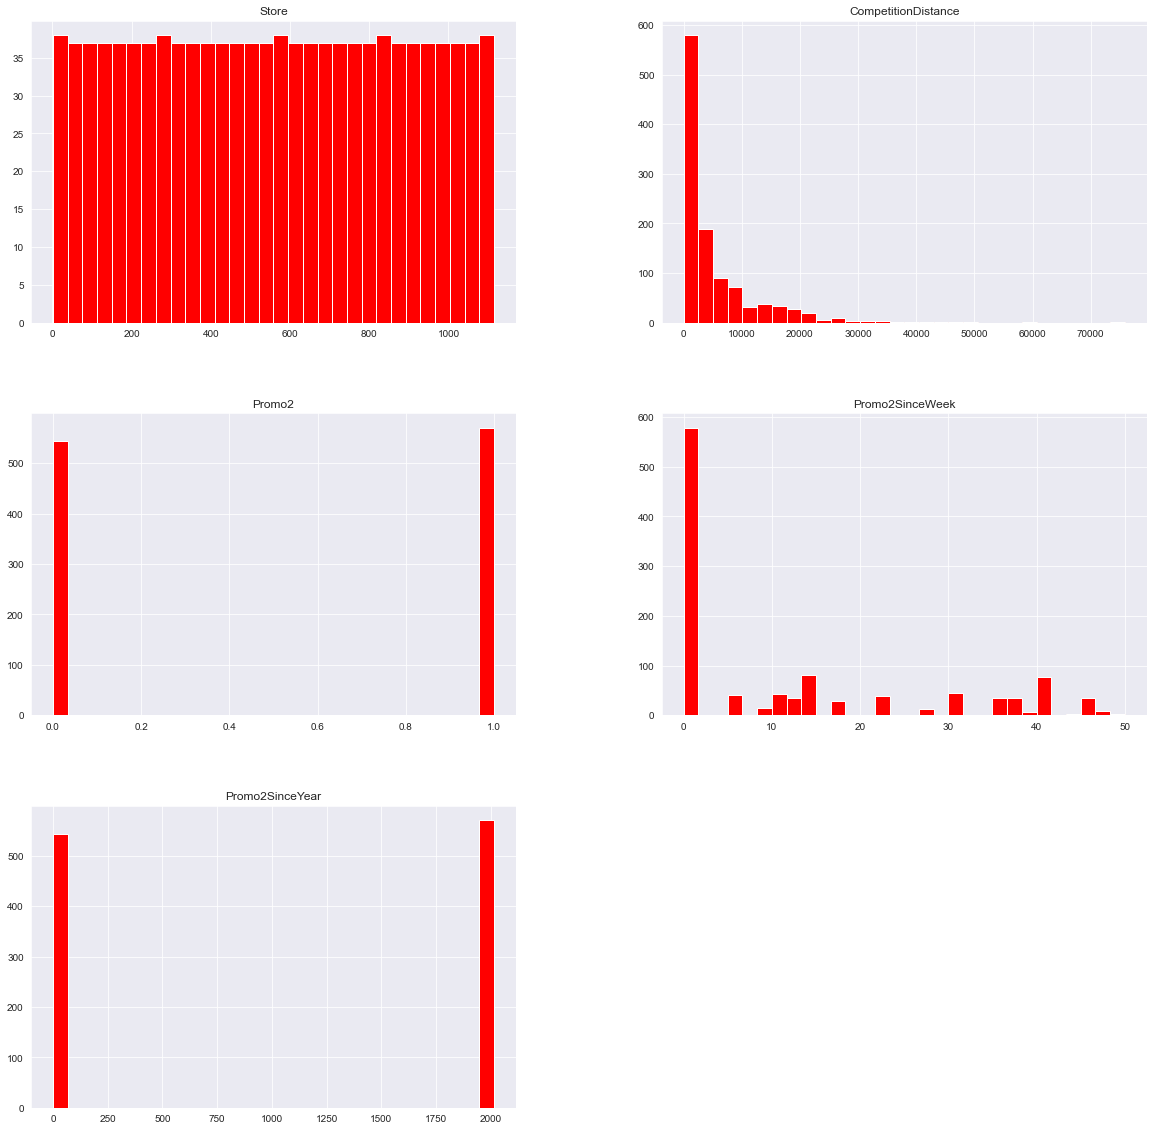

In [18]:
store_df.hist(bins = 30, figsize = (20,20), color = 'r')

From these graphs, some of the significant observations are that half of the stores are involved in promo 2. An excessive majority of the stores have ccompetitors closeby, at a distance of 0-3000m.

If we look at both datasets, we notice that both have a unique store ID. These unique IDs will be used to perfrom a merge between the two sets.

In [19]:
df = pd.merge(sales_df, store_df, how = 'inner', on = 'Store') 
df.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,0,0.0,0.0,0


Now that we have a merged df, lets look at how correlated the data is.

<Figure size 1440x1440 with 0 Axes>

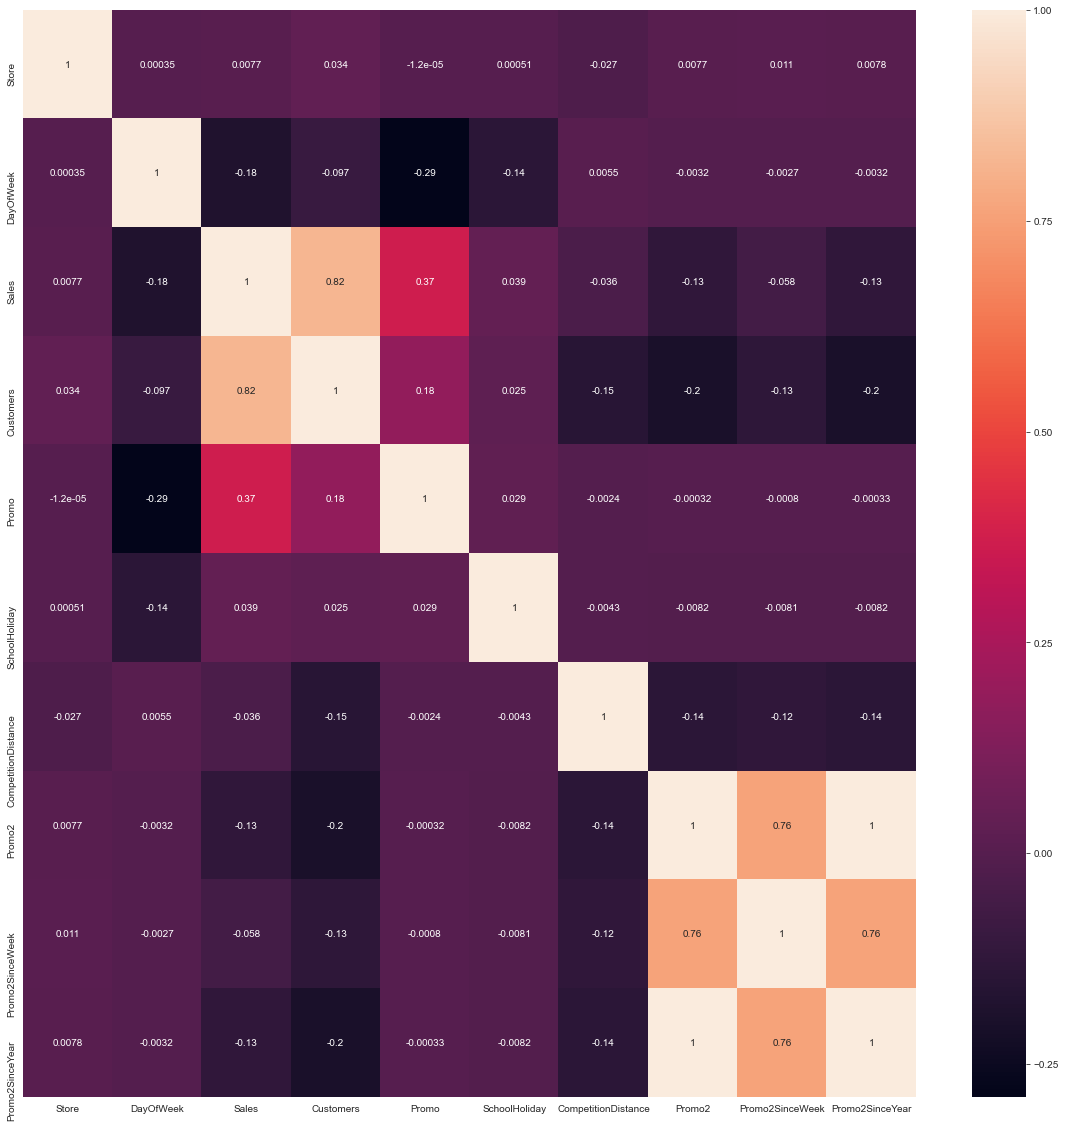

In [20]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

As expected, sales are highly correlated with the number of customers. However, Promo2 is negatively correlated with sales, but promo 1 is somewhat correlated with sales (average correlation).

Notice that our Date column has alot of information. It has the day, month and year. We could extract these as new features by using the datetime properties.

In [21]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day

We can now start visualizing sales with respect to months, years and days.

Text(0.5, 1.0, 'Average Sales Per Month')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Average Customers Per Month')

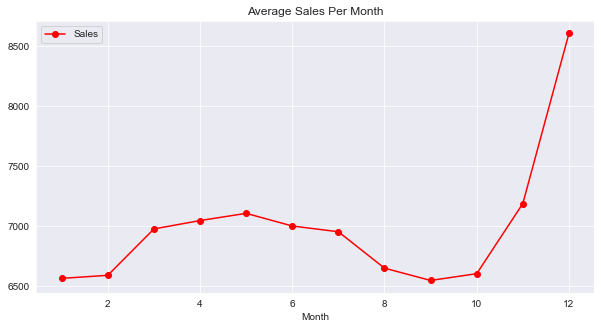

<Figure size 432x288 with 0 Axes>

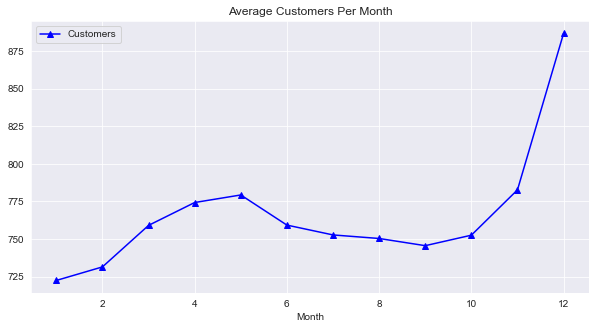

In [22]:
axis = df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

plt.figure()
axis = df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Month')


Sales and customers peak in December, which is Christmas month.

Text(0.5, 1.0, 'Average Sales Per Day')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Average Sales Per Day')

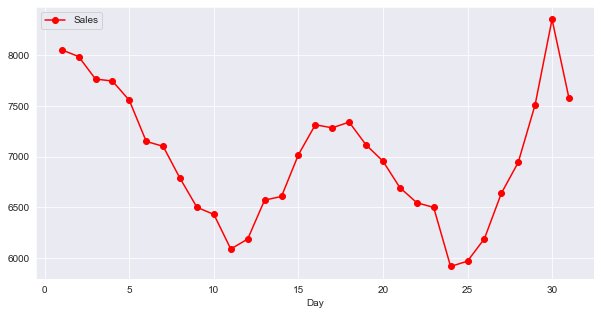

<Figure size 432x288 with 0 Axes>

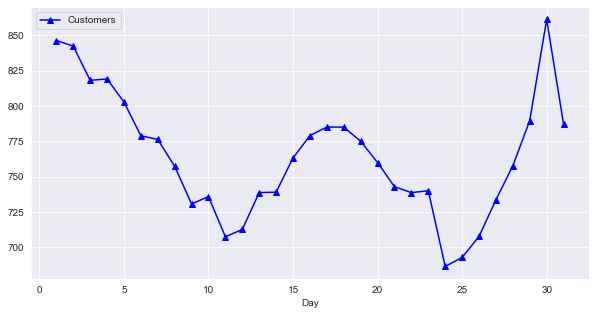

In [23]:
# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month
ax = df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

plt.figure()
ax = df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Sales Per Day')

Minimum number of customers are generally around the 24th of the month, while the number of customers and sales tend to peak at the end of the month. In Europe, salaries are paid monthly which may coincide with the rise of purchases around that time.

Text(0.5, 1.0, 'Average Sales Per Day of the Week')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Average Customers Per Day of the Week')

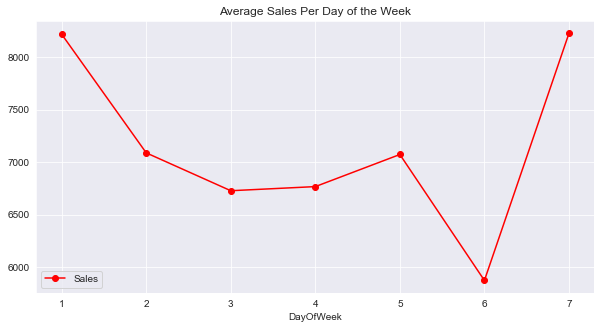

<Figure size 432x288 with 0 Axes>

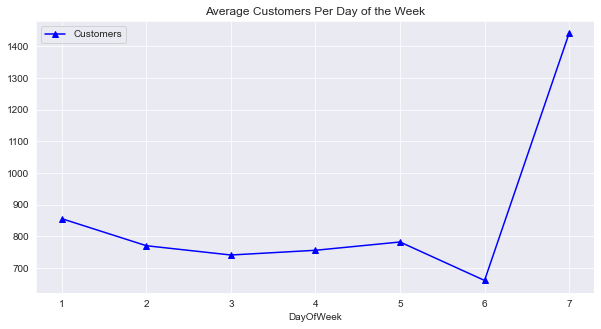

In [24]:
axis = df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the Week')

plt.figure()
axis = df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Average Customers Per Day of the Week')


The number of sales and customers are highest on Sunday. However, the customers that visit the store on Monday tend to buy more.

<Figure size 1080x720 with 0 Axes>

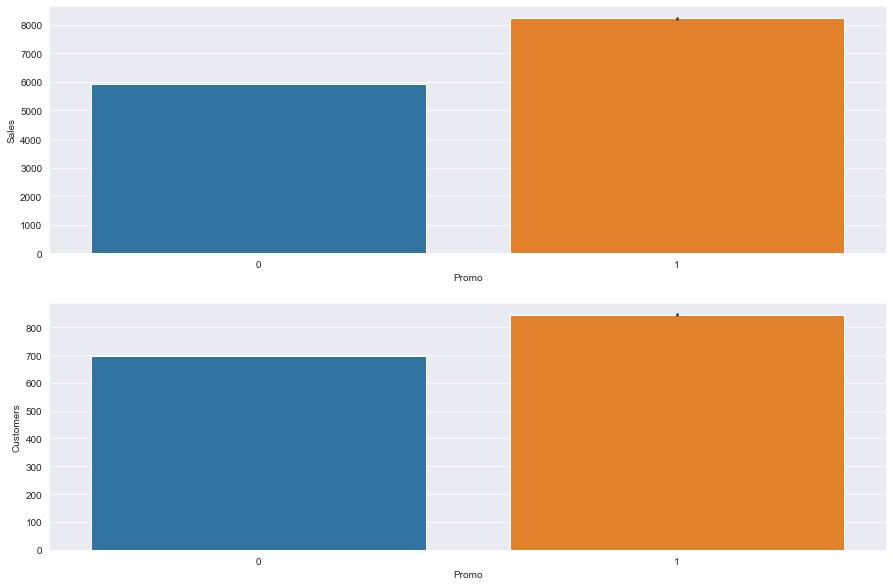

In [25]:
plt.figure(figsize=[15,10])

plt.subplot(211)
sns.barplot(x = 'Promo', y = 'Sales', data = df)

plt.subplot(212)
sns.barplot(x = 'Promo', y = 'Customers', data = df)

The graphs above shows us that when there is a promotion 1, the number of sales and customers increase.

To predict the future sales, we will be using the Prophet, a library for univariate time series forecasting developed by Facebook. The algorithm works very well if we have a lot of historical data and seasonality. It is accurate and fast, it is automatic (do not need data preprocessing) and is very flexible by adding domain knowledge on the fly. Let's implement it for our dataset. First, install Prophet by using the 'pip install fbprophet' command.

To use fbprophet, we need to rename our columns of Date to ds and sales to y. This is simply a requirment by the library. We wil also create a new dataframe for school and state holidays dates to feed into our Prophet function.

In [30]:
school_holidays = sales_df[sales_df['SchoolHoliday'] == 1].loc[:, 'Date'].values
state_holidays = sales_df [ (sales_df['StateHoliday'] == 'a') | (sales_df['StateHoliday'] == 'b') | (sales_df['StateHoliday'] == 'c')  ].loc[:, 'Date'].values

#Converting the dates to datetime format
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})

# concatenate both school and state holidays 
school_state_holidays = pd.concat((state_holidays, school_holidays))

In [32]:
from fbprophet import Prophet

def sales_prediction(Store_ID, sales_df, holidays, periods):
  # Function that takes in the data frame, storeID, and number of future period forecast
  # The function then generates date/sales columns in Prophet format
  # The function then makes time series predictions

  sales_df = sales_df[ sales_df['Store'] == Store_ID ]
  sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
  sales_df = sales_df.sort_values('ds')
  
  model    = Prophet(holidays=holidays)
  model.fit(sales_df)
  future   = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)
  figure   = model.plot(forecast, xlabel='Date', ylabel='Sales')
  figure2  = model.plot_components(forecast)

Now we can use the function above to make prediction by inputting the store number as first parameter, the dataframe as second parameter, holiday as third parameter and the number of future periods (days in this case) as the fourth.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


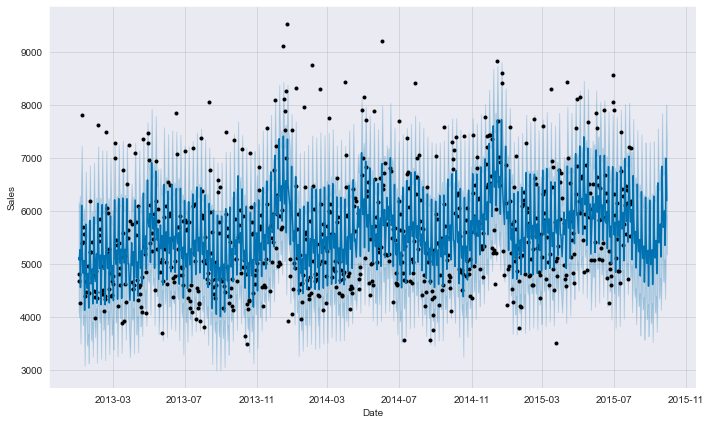

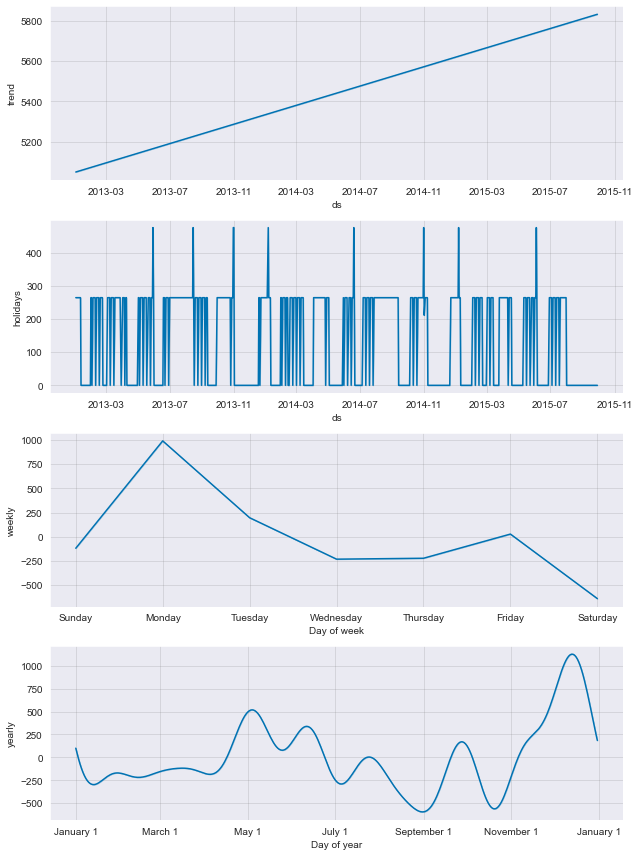

In [33]:
sales_prediction(10, df, school_state_holidays, 60)

The predicted sales are shown after the black dots stop. The black dots represents the historical data. We see that during the late summer and beginning of autumn, the sales will decrease as there will be less holidays. However, as we begin to approach November, the sales start to increase, until we hit a surge of sales in December during Christmas period due to boxing day and holiday shopping for presents.